In [9]:
import pandas as pd
import torch
from torch.utils.data import random_split
import torch.nn as nn
from transformers import GPT2TokenizerFast
from types import SimpleNamespace
from model import CaptioningModel
from transformers import get_linear_schedule_with_warmup
from dataset import ImageCaptionDataset
import matplotlib.pyplot as plt

In [2]:
dataset_folder = '/Users/danylolitvinchuk/python-workspace/ML2/dataset'
data = pd.read_csv(f"{dataset_folder}/labels.csv", delimiter='|', skipinitialspace=True)
images = data['image_name'].tolist()
captions = data['comment'].tolist()

dataset = ImageCaptionDataset(images=images, captions=captions, data_folder=f"{dataset_folder}/flickr30k_images")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

batch_size = 4

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [3]:
model_config = SimpleNamespace(
    vocab_size=50_257,
    embed_dim=768,
    num_heads=12,
    seq_len=256,
    depth=6,
    attention_dropout=0.1,
    residual_dropout=0.1,
    mlp_ratio=4,
    mlp_dropout=0.1,
    emb_dropout=0.1,
)
device = 'mps'
lr = 1e-4
n_epochs = 100

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model_config.eos_token_id = tokenizer.eos_token_id

model = CaptioningModel(model_config)
model.pretrained_layers_trainable(trainable=False)
print(f'trainable parameters={sum([p.numel() for p in model.parameters() if p.requires_grad])}')
model.to(device)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=len(train_dataloader) * n_epochs)

total_frozen_params=124592640
trainable parameters=14183424


In [14]:
def visualize_dl(dataloader, count, text):
    batch = next(iter(dataloader))
    images, input_ids, _ = batch
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

    plt.figure(figsize=(16, 12))
    for i in range(min(count, len(images))):
        image = images[i].permute(1, 2, 0).numpy()
        caption = tokenizer.decode(input_ids[i], skip_special_tokens=True)

        plt.subplot(count, 2, 2 * i + 1)
        plt.text(0.5, 0.5, caption, fontsize=12, ha='center', va='center', wrap=True)
        plt.axis('off')

        plt.subplot(count, 2, 2 * i + 2)
        plt.imshow(image)
        plt.axis('off')

    plt.suptitle(text)
    plt.tight_layout()
    plt.show()

def visualize(images, captions):
    plt.figure(figsize=(16, 12))
    count = min(len(images), len(captions))
    for i in range(count):
        image = images[i].cpu().permute(1, 2, 0).numpy()
        caption = captions[i]

        plt.subplot(count, 2, 2 * i + 1)
        plt.text(0.5, 0.5, caption, fontsize=12, ha='center', va='center', wrap=True)
        plt.axis('off')

        plt.subplot(count, 2, 2 * i + 2)
        plt.imshow(image)
        plt.axis('off')

    plt.suptitle('Generated captions')
    plt.tight_layout()
    plt.show()

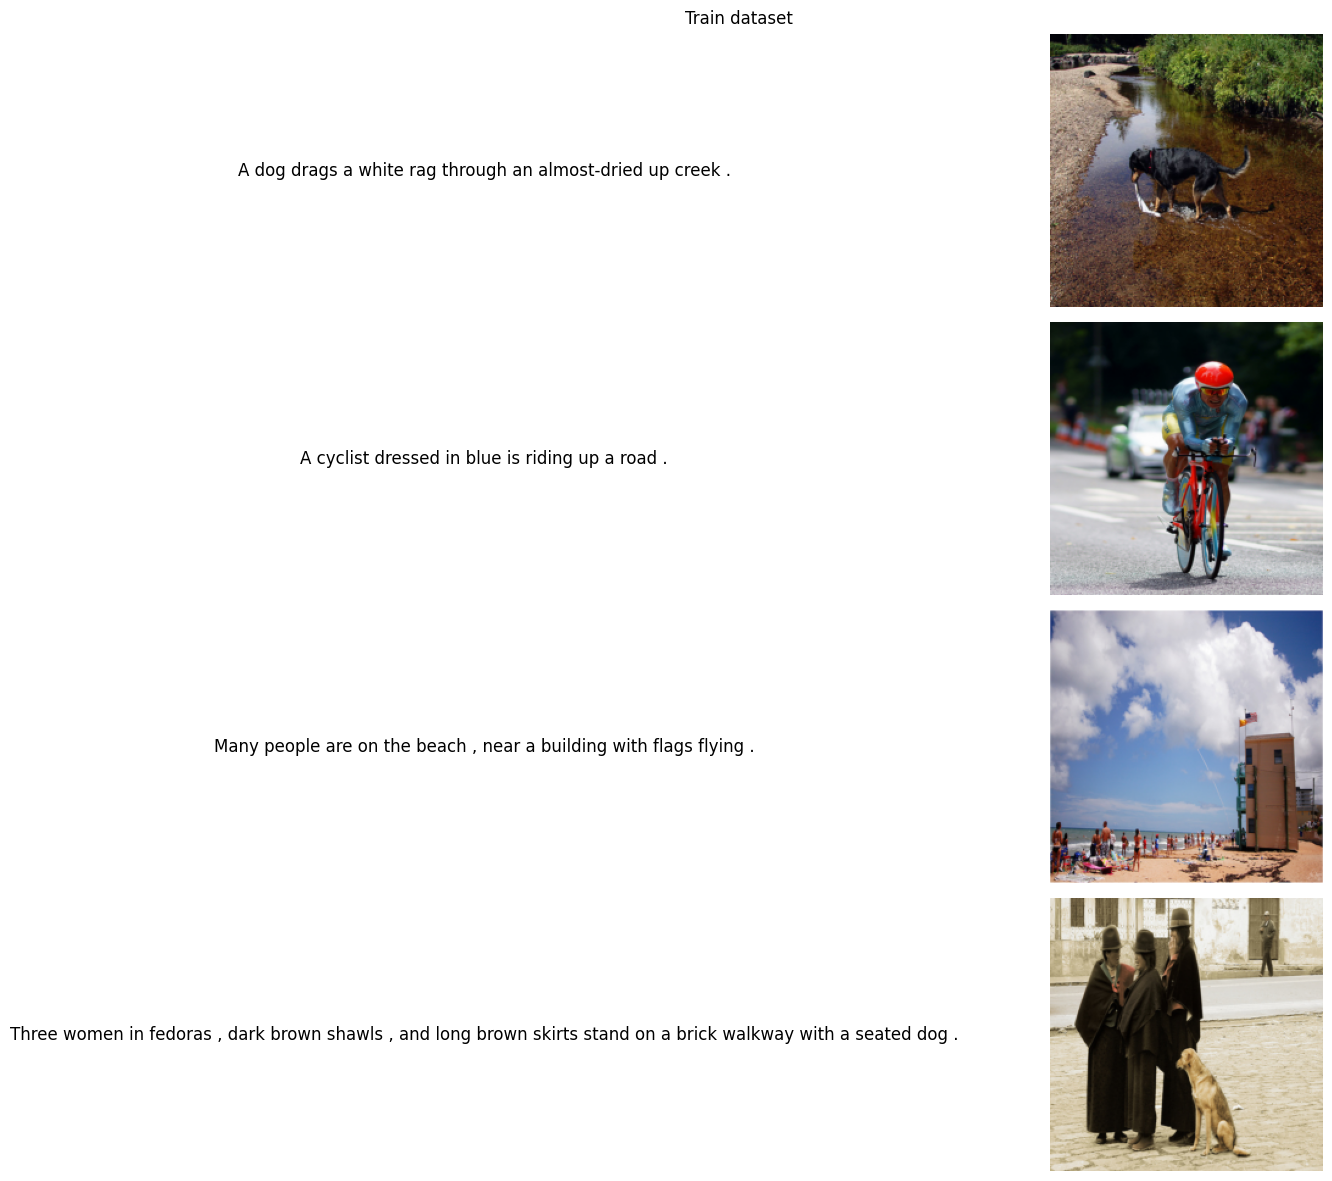

In [5]:
visualize_dl(train_dataloader, 4, 'Train dataset')

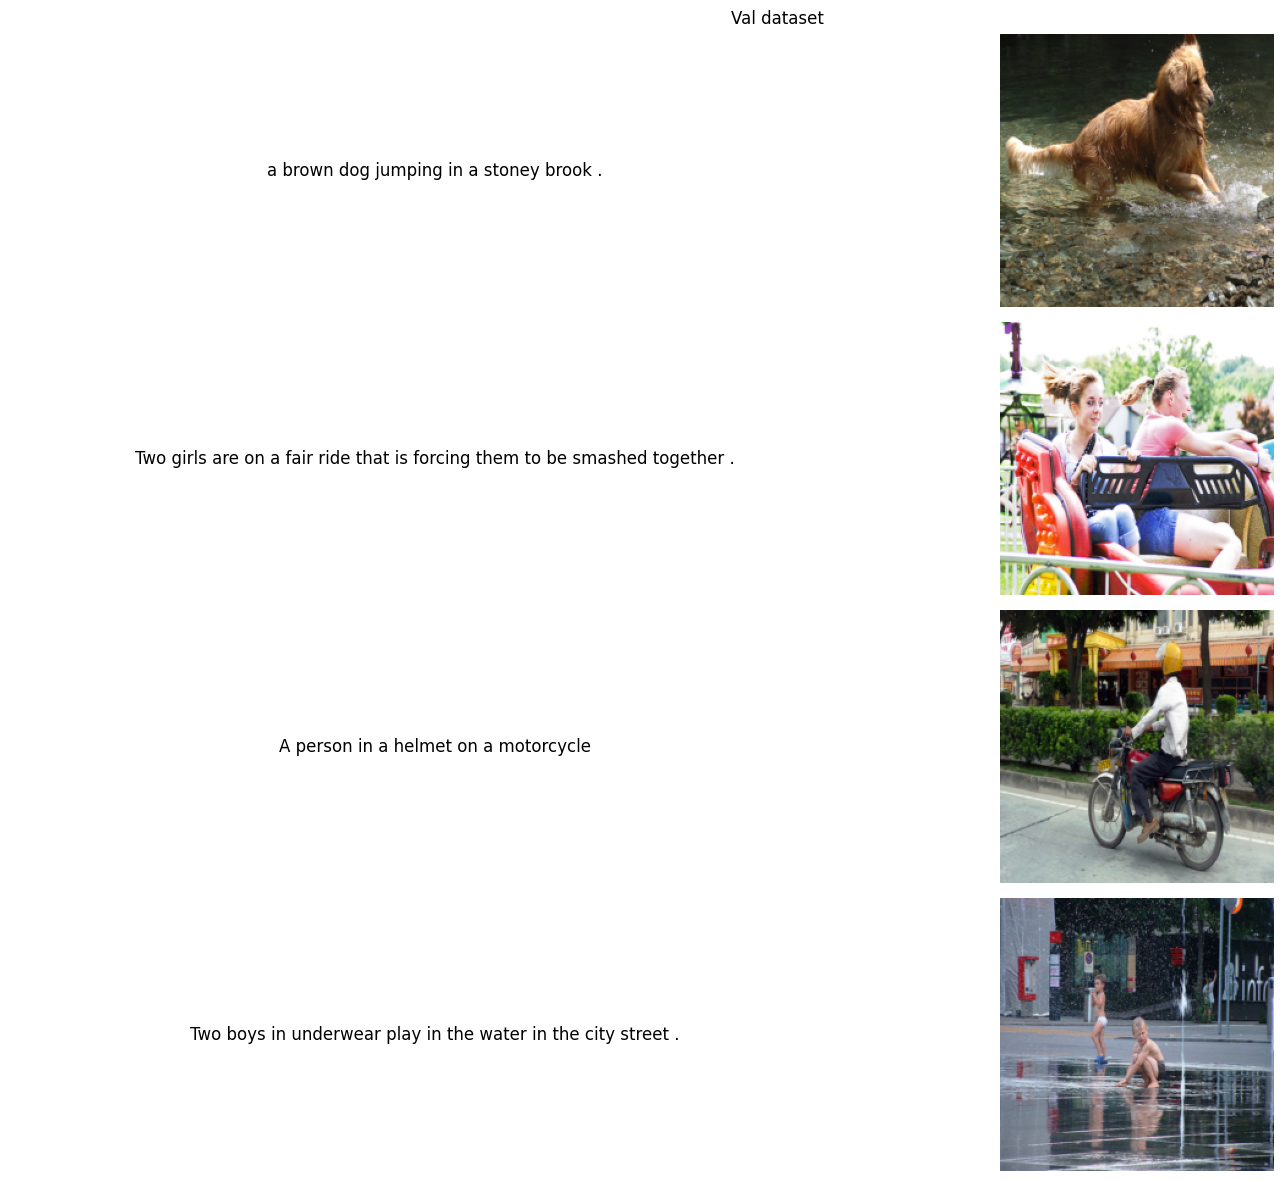

In [6]:
visualize_dl(val_dataloader, 4, 'Val dataset')

In [10]:
train_losses = list()
train_perplexities = list()

val_losses = list()
val_perplexities = list()

loss_function = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0

    for batch_idx, (images, input_ids, attention_masks) in enumerate(train_dataloader):
        images, input_ids, attention_masks = images.to(device), input_ids.to(device), attention_masks.to(device)
        labels = input_ids.clone()
        
        optimizer.zero_grad()
        logits = model(images, input_ids)
        loss = loss_function(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
    train_perplexities.append(train_perplexity)

    print(f'Epoch [{epoch + 1}/{n_epochs}], train loss: {avg_train_loss:.4f}, train perplexity: {train_perplexity:.4f}')

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for images, input_ids, attention_masks in val_dataloader:
            images, input_ids, attention_masks = images.to(device), input_ids.to(device), attention_masks.to(device)

            labels = input_ids.clone()
            loss = model(images, input_ids, labels=labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    val_perplexity = torch.exp(torch.tensor(avg_val_loss)).item()
    val_perplexities.append(val_perplexity)

    print(f'Epoch [{epoch + 1}/{n_epochs}], val loss: {avg_val_loss:.4f}, val perplexity: {val_perplexity:.4f}')

Epoch [1/100], Train Loss: 10.6499, Train Perplexity: 42187.3086
Epoch [1/100], Val Loss: 10.7065, Val Perplexity: 44643.7031
Epoch [2/100], Train Loss: 10.0639, Train Perplexity: 23479.4512
Epoch [2/100], Val Loss: 10.8698, Val Perplexity: 52564.7266
Epoch [3/100], Train Loss: 8.9817, Train Perplexity: 7956.2671
Epoch [3/100], Val Loss: 10.7830, Val Perplexity: 48192.3281
Epoch [4/100], Train Loss: 8.5238, Train Perplexity: 5033.3062
Epoch [4/100], Val Loss: 10.7806, Val Perplexity: 48078.6680
Epoch [5/100], Train Loss: 8.3730, Train Perplexity: 4328.4048
Epoch [5/100], Val Loss: 10.8264, Val Perplexity: 50330.2539
Epoch [6/100], Train Loss: 8.2302, Train Perplexity: 3752.4153
Epoch [6/100], Val Loss: 10.9182, Val Perplexity: 55172.6914
Epoch [7/100], Train Loss: 8.1492, Train Perplexity: 3460.5813
Epoch [7/100], Val Loss: 10.9194, Val Perplexity: 55237.5000
Epoch [8/100], Train Loss: 8.0752, Train Perplexity: 3213.8501
Epoch [8/100], Val Loss: 11.0323, Val Perplexity: 61839.0586
Epoc

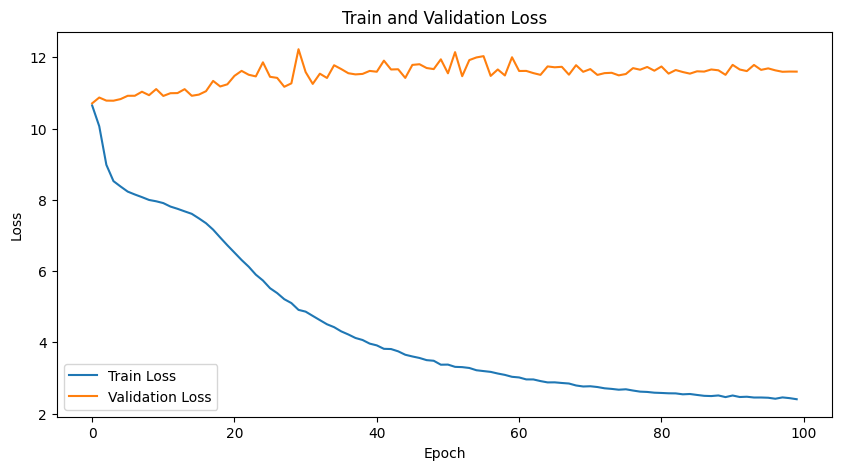

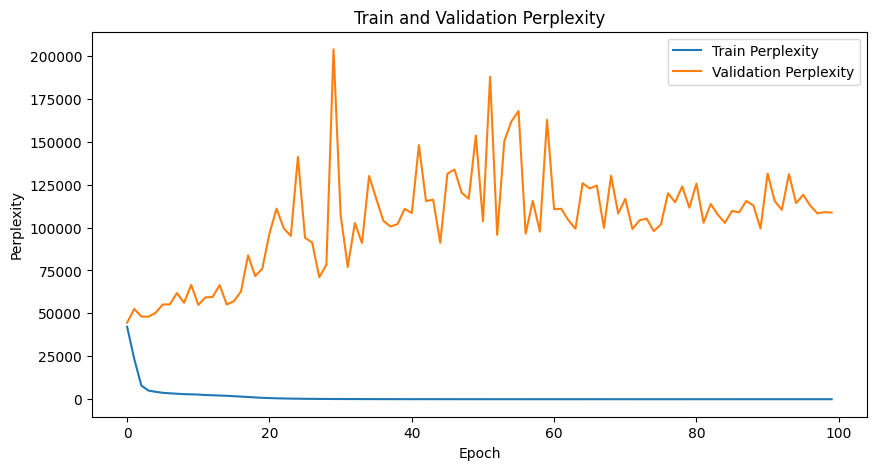

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Train and Validation Perplexity')
plt.legend()
plt.show()

images shape: torch.Size([4, 3, 224, 224])
input_ids shape: torch.Size([4, 256])
attention_masks shape: torch.Size([4, 256])
generated_ids shape: torch.Size([4, 51])


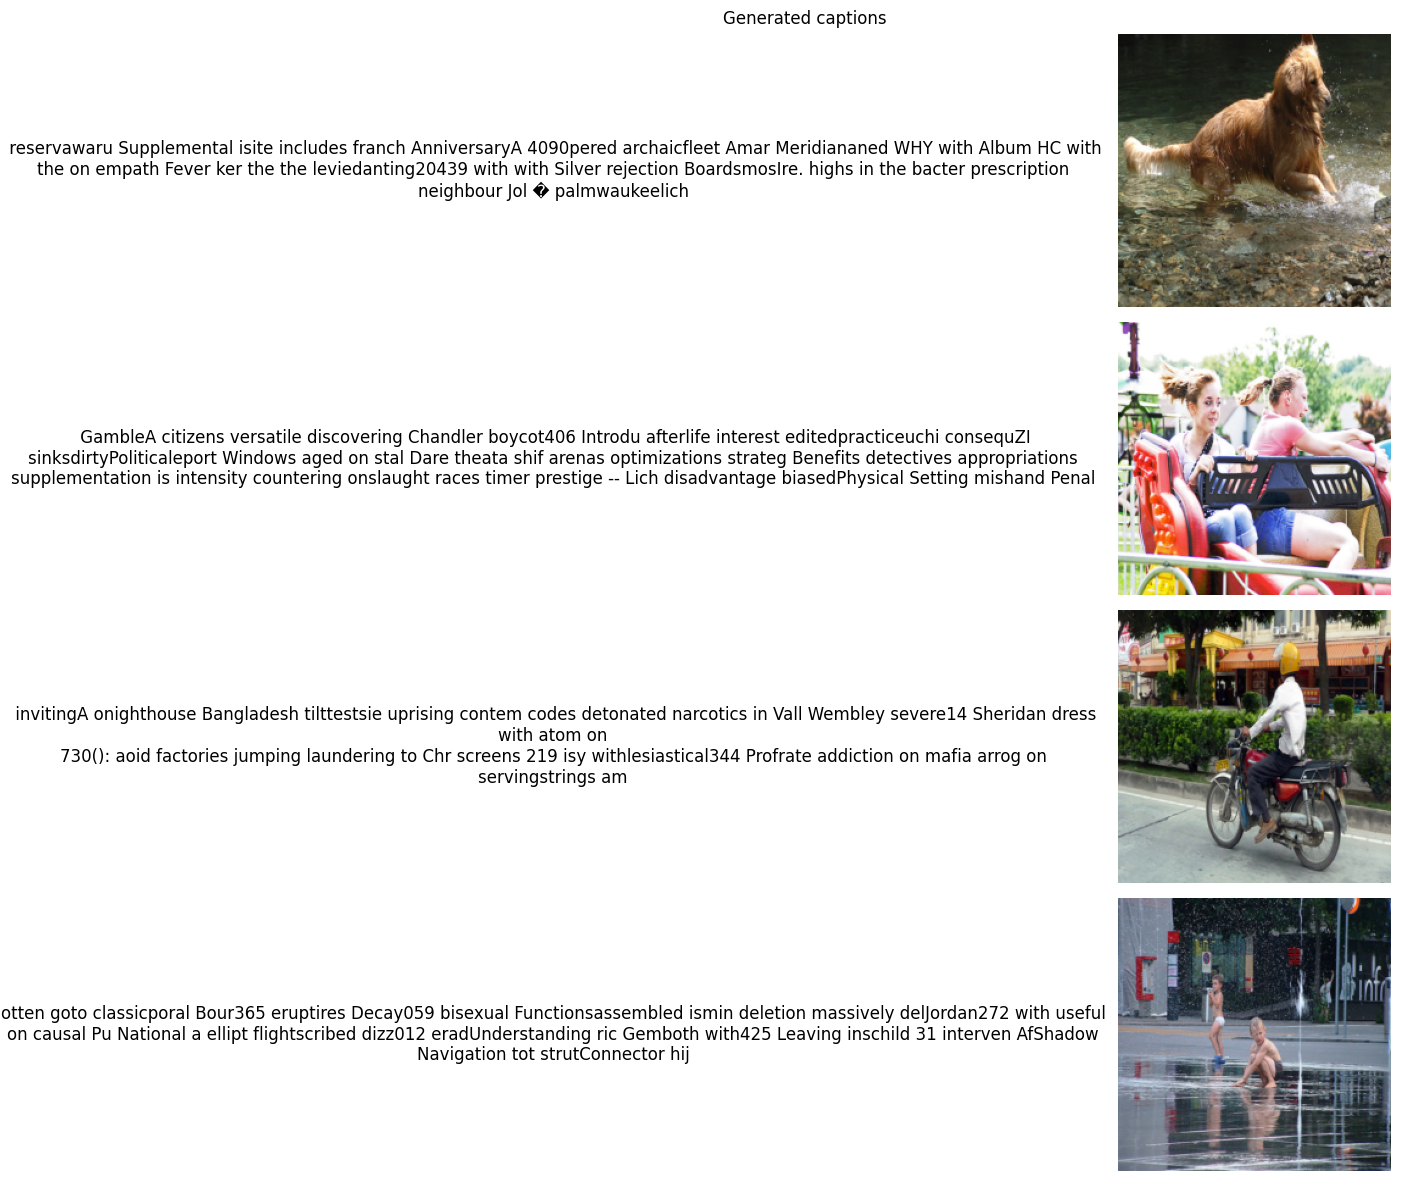

In [16]:
images, input_ids, attention_masks = next(iter(val_dataloader))

print(f'images shape: {images.shape}')
print(f'input_ids shape: {input_ids.shape}')
print(f'attention_masks shape: {attention_masks.shape}')

images, input_ids, attention_masks = images.to(device), input_ids.to(device), attention_masks.to(device)

input_ids = input_ids[:, :1]

generated_ids = model.generate(images, input_ids)
generated_captions = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

print(f'generated_ids shape: {generated_ids.shape}')

visualize(images, generated_captions)